### Abstract: Portuguese Vinho Verde: What Chemical Properties Are Significantly Associated With Blind Ratings of Wine Quality?

In [1]:
# Check encoding
import pandas as pd
import chardet
# Detect encoding with chardet
with open('data/Red Wine.csv', 'rb') as fraw:
    file_content = fraw.read(50000)
encoding = chardet.detect(file_content)['encoding']
# Load data
reds = pd.read_csv('data/Red Wine.csv', encoding = encoding, low_memory = False)
whites = pd.read_csv('data/White Wine.csv', encoding = encoding, low_memory = False)
print(reds.shape)
print(whites.shape)
# Concatenate reds and whites for larger sample size
data = pd.concat([reds, whites])
print(data.shape)

(1599, 12)
(4898, 12)
(6497, 12)


In [2]:
# Remove rows with NaN in target
print(data.quality.isna().sum())
data = data.dropna(subset = ['quality'])
print(data.shape)

0
(6497, 12)


In [3]:
# NaNs in features?
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

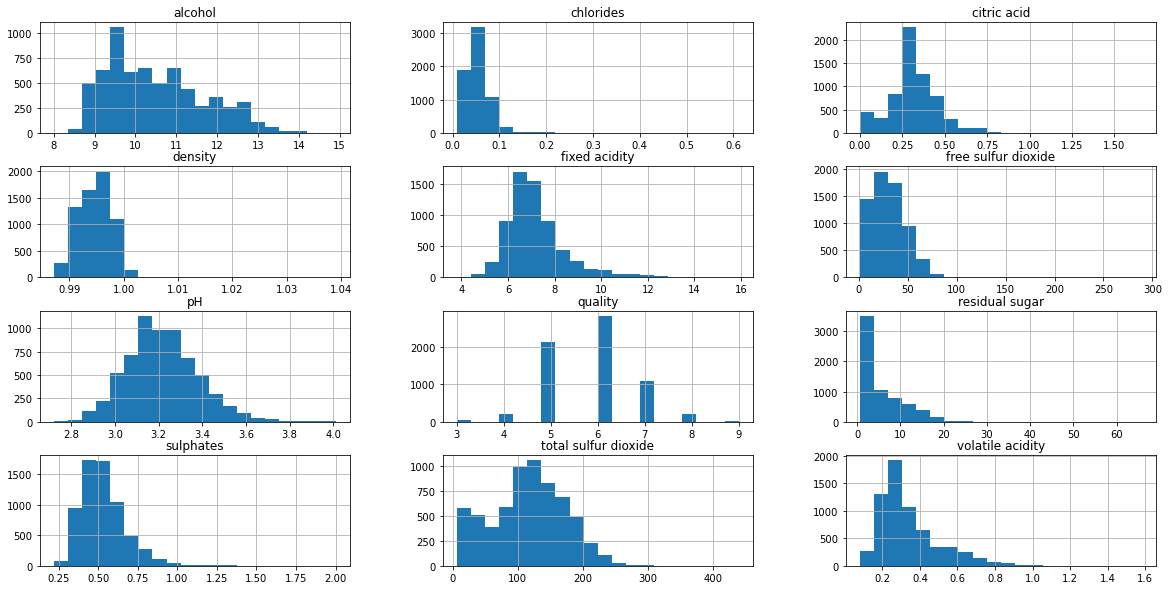

In [4]:
# Plot histograms
import matplotlib.pyplot as plt
import seaborn as sns
data.hist(bins = 20, figsize = (20, 10))
plt.savefig('images/all_histograms.png')

In [5]:
# # Normalize data
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# data_scaled = min_max_scaler.fit_transform(data)
# data = pd.DataFrame(data_scaled, columns = data.columns)

In [6]:
# # Plot normalized histograms
# import matplotlib.pyplot as plt
# import seaborn as sns
# data.hist(bins = 20, figsize = (20, 10))
# plt.savefig('images/normalized_histograms.png')

### From the paper describing the dataset: 

"Regarding the preferences, each sample was evaluated by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent). The final sensory score is given by the median of these evaluations."

In [7]:
# Train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, shuffle = True, test_size = 0.2, random_state = 20200917)
print(train.shape)
print(test.shape)

(5197, 12)
(1300, 12)


In [8]:
# Multiple regression
import statsmodels.api as sm
X = train.drop('quality', axis = 1)
y = train['quality']
X = sm.add_constant(X)
model = sm.OLS(y, X, hasconst= True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     192.7
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:13:46   Log-Likelihood:                -5766.2
No. Observations:                5197   AIC:                         1.156e+04
Df Residuals:                    5185   BIC:                         1.164e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   49.6847 

In [9]:
# Examine multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame(columns = ['Features', 'VIF'])
vif['Features'] = X.columns
for i in range(X.shape[1]):
    vif.loc[i, 'VIF'] = variance_inflation_factor(X.values, i).round(1)
# Remove constant row
vif = vif[1:]
# Sort by VIF
vif.sort_values('VIF', ascending = False)
# Density and residual sugar have VIF > 5

,Features,VIF
8,density,15.3
4,residual sugar,7.1
1,fixed acidity,4.8
11,alcohol,4.6
7,total sulfur dioxide,3
9,pH,2.5
6,free sulfur dioxide,2.2
2,volatile acidity,1.9
3,citric acid,1.6
5,chlorides,1.6


### Drop density feature
Density is negatively correlated with alcohol content (more alcohol = less dense) and positively correlated with residual sugar (more sugar = more dense) because alcohol is less dense than water and sugar is more dense than water. It seems like a feature that can be safely dropped.

In [10]:
# Multiple regression
X = train.drop(['quality', 'density'], axis = 1)
y = train['quality']
X = sm.add_constant(X)
model = sm.OLS(y, X, hasconst= True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     210.1
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:13:46   Log-Likelihood:                -5773.0
No. Observations:                5197   AIC:                         1.157e+04
Df Residuals:                    5186   BIC:                         1.164e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.9423 

In [11]:
# Examine multicollinearity
vif = pd.DataFrame(columns = ['Features', 'VIF'])
vif['Features'] = X.columns
for i in range(X.shape[1]):
    vif.loc[i, 'VIF'] = variance_inflation_factor(X.values, i).round(1)
# Remove constant row
vif = vif[1:]
# Sort by VIF
vif.sort_values('VIF', ascending = False)
# Now no features have VIF > 5

,Features,VIF
7,total sulfur dioxide,2.9
6,free sulfur dioxide,2.2
1,fixed acidity,1.8
2,volatile acidity,1.7
3,citric acid,1.6
5,chlorides,1.6
4,residual sugar,1.5
8,pH,1.4
9,sulphates,1.4
10,alcohol,1.4


### Drop alcohol feature
Alcohol content has the strongest positive correlation with quality. However, vinho verde ABV is associated with region, and the terroir and winemaking expertise of regions correlates with quality.

"The alcohol level of 'generic' Vinho Verde must lie between 8% and 11.5% ABV.  However, if the wine is labelled with one of the nine sub-regions, which specialise in particular grape varieties, the range extends from 9% to 14% ABV.  Additionally, Vinho Verde made from the single varietal Alvarinho can be between 11.5% and 14% ABV.  Finally, 'late harvest' Vinho Verde, made from over-ripe grapes with higher residual sugar content, normally has an alcoholic strength of around 15% ABV."*

Therefore, ABV is a confounding feature and should be dropped. Even if this hypothesis is false, including ABV in the model would mean that its predictions would be useless to a buyer who specifically desires a low ABV wine, since low ABV wines will be penalized with lower predicted quality scores. The authors of the paper comment on this ("For instance, an increase in the alcohol (4th and 2nd most relevant factor) tends to result in a higher quality wine."), but do not treat it as problematic.

*https://www.alcoholprofessor.com/blog-posts/blog/2014/04/23/vinho-verde-a-splash-of-summer-vinous-joy

In [12]:
# Multiple regression
X = train.drop(['quality', 'density', 'alcohol'], axis = 1)
y = train['quality']
X = sm.add_constant(X)
model = sm.OLS(y, X, hasconst= True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     96.91
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          7.56e-168
Time:                        13:13:46   Log-Likelihood:                -6253.0
No. Observations:                5197   AIC:                         1.253e+04
Df Residuals:                    5187   BIC:                         1.259e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.3490 

In [13]:
# Examine multicollinearity again
vif = pd.DataFrame(columns = ['Features', 'VIF'])
vif['Features'] = X.columns
for i in range(X.shape[1]):
    vif.loc[i, 'VIF'] = variance_inflation_factor(X.values, i).round(1)
# Remove constant row
vif = vif[1:]
# Sort by VIF
vif.sort_values('VIF', ascending = False)
# Now no features have VIF > 5

,Features,VIF
7,total sulfur dioxide,2.7
6,free sulfur dioxide,2.1
1,fixed acidity,1.7
2,volatile acidity,1.7
3,citric acid,1.6
4,residual sugar,1.4
5,chlorides,1.4
8,pH,1.4
9,sulphates,1.4


In [14]:
# Drop multicollinear features that measure similar chemical property (free sulfur dioxide, fixed acidity)
X = train.drop(['quality', 'density', 'alcohol', 'free sulfur dioxide', 'fixed acidity'], axis = 1)
y = train['quality']
X = sm.add_constant(X)
model = sm.OLS(y, X, hasconst= True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     113.1
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          5.76e-155
Time:                        13:13:46   Log-Likelihood:                -6287.7
No. Observations:                5197   AIC:                         1.259e+04
Df Residuals:                    5189   BIC:                         1.264e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6540 

### Backward selection
Now that high multicollinearity features (density) and confounding/irrelevant features (alcohol) have been removed, the model will be simplified via backward selection: Remove less significant features (residual sugar, pH, citric acid).

In [15]:
# Multiple regression
X = train.drop(['quality', 'density', 'alcohol', 'free sulfur dioxide', 'fixed acidity', 'residual sugar', 'pH', 'citric acid'], axis = 1)
y = train['quality']
X = sm.add_constant(X)
model = sm.OLS(y, X, hasconst= True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     194.2
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          2.28e-155
Time:                        13:13:46   Log-Likelihood:                -6294.6
No. Observations:                5197   AIC:                         1.260e+04
Df Residuals:                    5192   BIC:                         1.263e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.5106 

In [16]:
# Examine multicollinearity again
vif = pd.DataFrame(columns = ['Features', 'VIF'])
vif['Features'] = X.columns
for i in range(X.shape[1]):
    vif.loc[i, 'VIF'] = variance_inflation_factor(X.values, i).round(1)
# Remove constant row
vif = vif[1:]
# Sort by VIF
vif.sort_values('VIF', ascending = False)
# Now no features have VIF > 5

,Features,VIF
1,volatile acidity,1.3
2,chlorides,1.3
3,total sulfur dioxide,1.3
4,sulphates,1.2


### Notes
Volatile acidity is a measure of wine spoilage. Chlorides are a measure of saltiness, which can be caused by terroir or varietal. These "bad wine" features have the strongest correlations of the remaining features. Simplify model to only these features.

*https://winemakermag.com/article/676-the-perils-of-volatile-acidity

*https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-20612015000100095

In [17]:
# More backward selection: Multiple regression with the two features with largest betas
X = train[['volatile acidity', 'chlorides']]
y = train['quality']
X = sm.add_constant(X)
model = sm.OLS(y, X, hasconst= True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     227.9
Date:                Fri, 02 Oct 2020   Prob (F-statistic):           1.31e-95
Time:                        13:13:46   Log-Likelihood:                -6438.3
No. Observations:                5197   AIC:                         1.288e+04
Df Residuals:                    5194   BIC:                         1.290e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.3697      0.028  

### Mixed selection
R squared drops from 14% to 8%. Add back in the two next two largest betas

In [18]:
# Multiple regression with the top four largest betas
X = train[['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates']]
y = train['quality']
X = sm.add_constant(X)
model = sm.OLS(y, X, hasconst= True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     194.2
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          2.28e-155
Time:                        13:13:46   Log-Likelihood:                -6294.6
No. Observations:                5197   AIC:                         1.260e+04
Df Residuals:                    5192   BIC:                         1.263e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.5106 

### Notes
Sulfur dioxide is a natural byproduct of wine fermentation and aid in preserving wine. However, some winemakers will add additional sulfur dioxide for even more preservation. According to the source, sulfites in normal quantities have no affect on flavor, however there appears to be a negative association with quality in the multiple regression. In the total sulfur dioxide histogram, there appears to be a bimodal distribution, perhaps pointing to winemakers that add extra artificial sulfur dioxide, perhaps in order to compensate for bad winemaking practice/technique. In this case, total sulfur dioxide may be a proxy for bad winemaking practice/technique. Maybe there is an interaction with volatile acidity, a measure of spoilage.

"Sulphates" are measured in this study, which refer to potassium sulfate, which should not be confused with potassium sulfite. While potassium sulfite is used as a precursor to sulfite dioxide to artificially preserve wines, potassium sulfate is used in fertilizer to provide potassium to the grapes. Maybe there is an interaction with chlorides, a measure of terrior/varietal. From the paper: "The most intriguing result is the high importance of sulphates, ranked first for both cases. Oenologically this result could be very interesting. An increase in sulphates might be related to the fermenting nutrition, which is very important to improve the wine aroma."

https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377?via%3Dihub

https://learn.winecoolerdirect.com/wine-sulfites/

https://grapesandwine.cals.cornell.edu/newsletters/appellation-cornell/2018-newsletters/issue-33-may-2018-0/grapes-101/

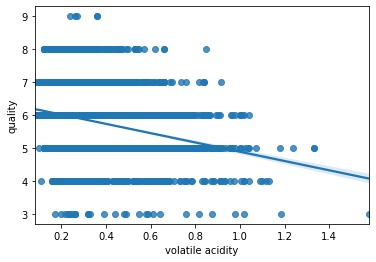

In [19]:
# Examine univariate regression lines
plot = sns.regplot(data['volatile acidity'], data['quality'])
plot.figure.savefig('images/corr_volatile acidity.png')

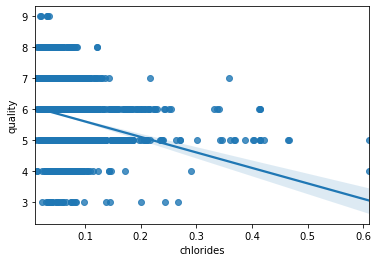

In [20]:
# Examine univariate regression lines
plot = sns.regplot(data['chlorides'], data['quality'])
plot.figure.savefig('images/corr_chlorides.png')

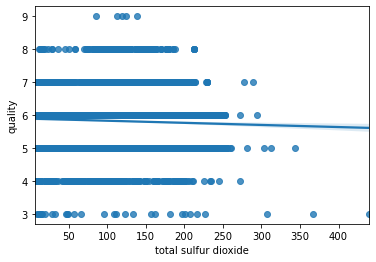

In [21]:
# Examine univariate regression lines
plot = sns.regplot(data['total sulfur dioxide'], data['quality'])
plot.figure.savefig('images/corr_total sulfur dioxide.png')

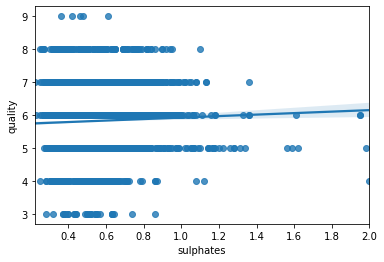

In [22]:
# Examine univariate regression lines
plot = sns.regplot(data['sulphates'], data['quality'])
plot.figure.savefig('images/corr_sulphates.png')

Interestingly, it appears that the negative coefficient features are driven by the tails of lower quality wines, whereas sulphates (the positive coefficient feature) is driven by the tails of average quality wines. Why does including them add 6% to the R2? Especially since their coefficients are so small? Maybe it is that while volatile acidity and chlorides are general bad features of bad wines, total sulfur dioxide is a bad feature specific to very bad wines, and sulphates are a good feature specific to average wines. So the two features aid in predicting quality in those specific domains.

In [23]:
# # Model interactions
# import statsmodels.formula.api as smf
# X_interactions = sm.add_constant(X)
# X_interactions['quality'] = y
# X_interactions.columns = X_interactions.columns.str.replace(' ', '')
# model_interaction = smf.ols(formula = 'quality ~ volatileacidity + totalsulfurdioxide + chlorides + sulphates + \
#     + volatileacidity*totalsulfurdioxide + chlorides*sulphates', data = X_interactions, hasconst= True)
# results_interaction = model_interaction.fit()
# print(results_interaction.summary())

In [24]:
# Prediction
X_test = test[['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates']]
X_test.columns = X_test.columns.str.replace(' ', '')
X_test = sm.add_constant(X_test)
y_test = test['quality']
y_pred = results.predict(X_test)
residuals = y_test - y_pred

Of 6 possible ratings in the test set, chance performance would be 1/6 ~ 17%
0.6 mean difference from true value
47.0 % predicted correctly
80.0 % predicted correctly within one point


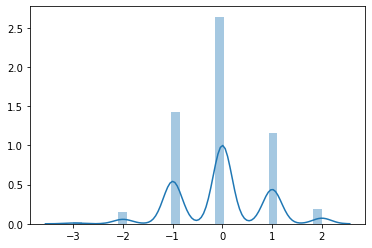

In [25]:
# Round predictions to nearest integer to match test format
y_pred_rounded = y_pred.round()
residuals_rounded = y_test - y_pred_rounded
sns.distplot(residuals_rounded)
print('Of 6 possible ratings in the test set, chance performance would be 1/6 ~ 17%')
print(round(residuals_rounded.abs().mean(),2) , 'mean difference from true value')
print(round(sum(residuals_rounded == 0) / len(residuals)*100, 0), '% predicted correctly')
print(round(len(residuals[residuals.between(-1, 1)])/len(residuals)*100, 0), '% predicted correctly within one point')

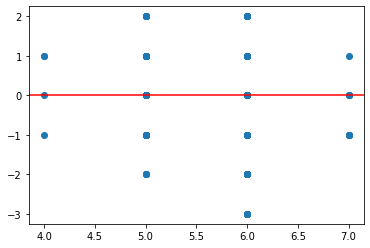

In [26]:
# Plot residuals against predictions, check that errors are normally distributed
plt.scatter(y_pred_rounded, residuals_rounded)
plt.axhline(y = 0, color = 'red', label = '0')